In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import cv2
import opencv_jupyter_ui
import matplotlib.pyplot as plt
from collections import defaultdict
import calendar

In [2]:
#Read in the data
data = pd.read_csv("Lekagul Sensor Data.csv")
data

,Timestamp,car-id,car-type,gate-name
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2
...,...,...,...,...
171472,2016-05-31 23:40:13,20161031111001-854,6,ranger-stop2
171473,2016-05-31 23:42:08,20165831105856-579,1,general-gate4
171474,2016-05-31 23:43:13,20161031111001-854,6,general-gate1
171475,2016-05-31 23:49:45,20165831105856-579,1,general-gate7


In [3]:
#Check each column's data type
data.dtypes

Timestamp    object
car-id       object
car-type     object
gate-name    object
dtype: object

In [4]:
#Check for nulls
data.isna().sum()

Timestamp    0
car-id       0
car-type     0
gate-name    0
dtype: int64

In [5]:
#Change variables to appropriate type
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['car-type'] = data['car-type'].astype('category')
data['gate-name'] = data['gate-name'].astype('category')

data

,Timestamp,car-id,car-type,gate-name
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2
...,...,...,...,...
171472,2016-05-31 23:40:13,20161031111001-854,6,ranger-stop2
171473,2016-05-31 23:42:08,20165831105856-579,1,general-gate4
171474,2016-05-31 23:43:13,20161031111001-854,6,general-gate1
171475,2016-05-31 23:49:45,20165831105856-579,1,general-gate7


In [6]:
#Check each column's data type again
data.dtypes

Timestamp    datetime64[ns]
car-id               object
car-type           category
gate-name          category
dtype: object

In [7]:
#Describe the statistics of the base data
data.describe()

/var/folders/dq/pfq3tvqs1wv176zp5xp2dfs80000gn/T/ipykernel_7975/2146467897.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,Timestamp,car-id,car-type,gate-name
count,171477,171477,171477,171477
unique,170298,18708,7,40
top,2015-07-31 12:00:02,20154519024544-322,1,general-gate7
freq,5,281,67698,16119
first,2015-05-01 00:43:28,NaN,NaN,NaN
last,2016-05-31 23:56:06,NaN,NaN,NaN


array([[<AxesSubplot:title={'center':'Timestamp'}>]], dtype=object)

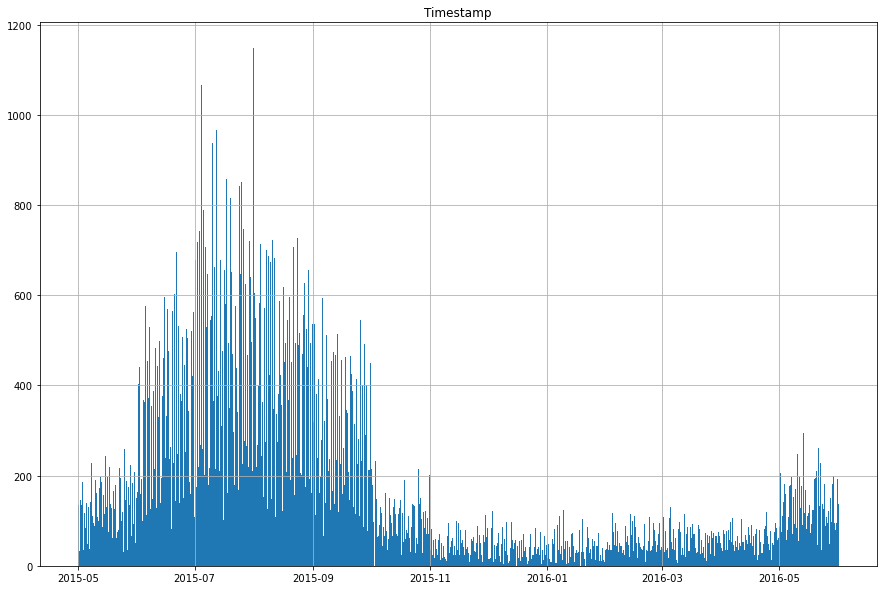

In [8]:
#Visualize distribution of each column & outliers
data.hist(bins=1000, figsize=(15, 10))

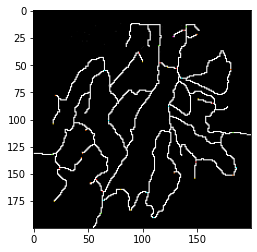

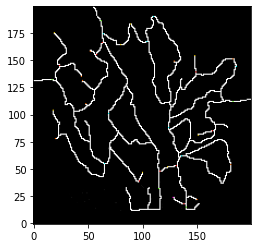

(<matplotlib.image.AxesImage at 0x1329a8190>, None, None)

In [9]:
#load in bmp
img = cv2.imread('Lekagul Roadways.bmp')
flip = img[::-1,:,:]
pixel_values = flip[:,:,::-1]
plt.imshow(flip[:,:,::-1],vmin=0,vmax=255), plt.show()
plt.imshow(flip[:,:,::-1]), plt.gca().invert_yaxis(), plt.show()

In [10]:
#color names

# (0, 0, 0), black
#  (0, 255, 255), cyan
#  (1, 1, 1), black
#  (2, 2, 2), black
#  (3, 3, 3), black
#  (5, 5, 5), black
#  (6, 6, 6), black
#  (8, 8, 8), black
#  (9, 9, 9), black
#  (14, 14, 14), black
#  (16, 16, 16),black
#  (17, 17, 17),black
#  (18, 18, 18),black
#  (19, 19, 19),black
#  (20, 20, 20),black
#  (21, 21, 21),black
#  (22, 22, 22),black
#  (23, 23, 23),black
#  (24, 24, 24),black
#  (25, 25, 25),black
#  (31, 31, 31),black
#  (46, 46, 46),black
#  (64, 64, 64),black
#  (65, 65, 65),black
#  (66, 66, 66),black
#  (67, 67, 67),black
#  (68, 68, 68),black
#  (70, 70, 70),black
#  (72, 72, 72),black
#  (76, 255, 0),green
#  (239, 239, 239),yellow
#  (255, 0, 0),red
#  (255, 0, 220),pink
#  (255, 106, 0),orange
#  (255, 216, 0),orange
#  (255, 255, 255)white

In [11]:
#create np.array grid
# replace color values with sensor names
# 'R' signifies a road
# '.' signifies empty space
grid = [['.' for i in range(200)] for j in range(200)]

for y in range(len(pixel_values)):
    for x in range(len(pixel_values[y])):
        if (pixel_values[x][y] == [0, 255, 255]).all():
            grid[x][y] = 'General_Gate'
        elif (pixel_values[x][y] == [76, 255, 0]).all():
            grid[x][y] = 'Entrance'
        elif (pixel_values[x][y] == [255, 216, 0]).all():
            grid[x][y] = 'Ranger_Stop'
        elif (pixel_values[x][y] == [255, 0, 0]).all():
            grid[x][y] = 'Gate'
        elif (pixel_values[x][y] == [255, 0, 220]).all():
            grid[x][y] = 'Ranger_Base'
        elif (pixel_values[x][y] == [255, 106, 0]).all():
            grid[x][y] = 'Camping'
        elif (pixel_values[x][y] == [255, 255, 255]).all():
            grid[x][y] = 'R'
        else:
            continue

In [ ]:
#get just the coordinates of the sensors

color_map = []
for x in range(len(grid)):
    for y in range(len(grid[x])):
        if grid[x][y] == ".":
            continue
        else:
            color_map.append([grid[x][y], (y,x)])


In [13]:
#Recursive function to find the shortest path along the roads

def find_dist(start, end, count, checked = None ):
    if checked is None:
	    checked = []
    checked.append(start)

    if start == end:
        return count

    else:
        if (['R', (start[0] + 1, start[1])] in color_map and (start[0] + 1, start[1]) not in checked) or (end == (start[0] + 1, start[1])):
            count += 1
            res = find_dist((start[0] + 1, start[1]), end, count, checked)
            if res is not None:
                return res
        if (['R', (start[0], start[1] + 1)] in color_map and (start[0], start[1] + 1) not in checked) or (end == (start[0], start[1] + 1)):
            count += 1
            res = find_dist((start[0], start[1] + 1), end, count, checked)
            if res is not None:
                return res
        if (['R', (start[0] - 1, start[1])] in color_map and (start[0] - 1, start[1]) not in checked) or (end == (start[0] - 1, start[1])):
            count += 1
            res = find_dist((start[0] - 1, start[1]), end, count, checked)
            if res is not None:
                return res
        if (['R', (start[0], start[1] - 1)] in color_map and (start[0], start[1] - 1) not in checked) or (end == (start[0], start[1] - 1)):
            count += 1
            res = find_dist((start[0], start[1] - 1), end, count, checked)
            if res is not None:
                return res

In [14]:
#create graph of all sensors

g = {"Entrance_0": {'General_gate_1', 'Gate_0', 'General_gate_4', 'General_gate_7', 'Gate_7', 'Gate_6', 'Entrance_3'},
     "Entrance_1": {'Gate_2', 'Camping_2', 'Camping_3', 'Camping_4', 'Camping_0', 'Gate_1', 'General_gate_7'},
     "Entrance_2": {'General_gate_3', 'Gate_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2', 'General_gate_5', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "Entrance_3": {'Gate_6', 'Gate_7', 'General_gate_7', 'General_gate_4', 'Gate_0', 'General_gate_1', 'Entrance_0'},
     "Entrance_4": {'Gate_8', 'Camping_6', 'Gate_5', 'General_gate_6', 'Gate_4', 'Entrance_2', 'General_gate_3', 'General_gate_5', 'Gate_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "Gate_0": {'Gate_1', 'Entrance_0', 'General_gate_1', 'General_gate_4', 'Gate_6', 'Entrance_3', 'General_gate_7', 'Gate_7'},
     "Gate_1": {'Camping_0', 'Gate_0', 'Camping_3', 'Camping_4', 'Entrance_1', 'Gate_2', 'Camping_2', 'General_gate_7'},
     "Gate_2": {'Ranger_stop_1', 'Camping_2', 'Entrance_1', 'Camping_4', 'Camping_3', 'Camping_0', 'Gate_1', 'General_gate_7'},
     "Gate_3": {'Ranger_stop_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2', 'General_gate_5', 'General_gate_3', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "Gate_4": {'Ranger_stop_5', 'Entrance_2', 'General_gate_3', 'General_gate_5', 'Gate_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "Gate_5": {'Ranger_stop_6', 'Camping_6', 'Gate_8', 'Entrance_4', 'General_gate_6', 'General_gate_5', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Camping_8', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_0'},
     "Gate_6": {'Ranger_stop_6', 'Entrance_3', 'Entrance_0', 'General_gate_1', 'Gate_0', 'General_gate_4', 'General_gate_7', 'Gate_7'},
     "Gate_7": {'Ranger_stop_7', 'General_gate_7', 'General_gate_4', 'Gate_6', 'Entrance_3', 'Gate_0', 'General_gate_1', 'Entrance_0'},
     "Gate_8": {'Ranger_base', 'Entrance_4', 'Camping_6', 'Gate_5', 'General_gate_6', 'General_gate_5', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Camping_8', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "Camping_0": {'Gate_1', 'Camping_3', 'Camping_4', 'Entrance_1', 'Gate_2', 'Camping_2', 'General_gate_7'},
     "Camping_1": {'General_gate_0', 'General_gate_2', 'General_gate_5', 'Gate_3', 'Camping_8', 'General_gate_3', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "Camping_2": {'Gate_2', 'Entrance_1', 'Camping_4', 'Camping_3', 'Camping_0', 'Gate_1', 'General_gate_7'},
     "Camping_3": {'Gate_1', 'Camping_0', 'Camping_4', 'Entrance_1', 'Gate_2', 'Camping_2', 'General_gate_7'},
     "Camping_4": {'General_gate_7', 'Gate_1', 'Camping_0', 'Camping_3', 'Entrance_1', 'Gate_2', 'Camping_2'},
     "Camping_5": {'Ranger_stop_4', 'General_gate_7'},
     "Camping_6": {'Entrance_4', 'Gate_8', 'Gate_5', 'General_gate_6', 'General_gate_5', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Gate_3', 'Camping_8', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "Camping_7": {'General_gate_6'},
     "Camping_8": {'General_gate_3', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2', 'General_gate_5', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "General_gate_0": {'General_gate_2', 'Camping_1', 'Gate_3', 'Camping_8', 'General_gate_5', 'General_gate_3', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "General_gate_1": {'Entrance_0', 'Gate_0', 'Ranger_stop_2', 'General_gate_4', 'Gate_6', 'Entrance_3', 'General_gate_7', 'Gate_7'},
     "General_gate_2": {'Ranger_stop_0', 'General_gate_0', 'Camping_1', 'General_gate_5', 'Gate_3', 'Camping_8', 'General_gate_3', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4'},
     "General_gate_3": {'Camping_8', 'Entrance_2', 'Gate_4', 'General_gate_6', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4', 'General_gate_5', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "General_gate_4": {'Entrance_0', 'General_gate_1', 'Gate_0', 'Gate_6', 'Entrance_3', 'Gate_7', 'General_gate_7'},
     "General_gate_5": {'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4', 'General_gate_6', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Camping_8', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "General_gate_6": {'Camping_7', 'Gate_5', 'Camping_6', 'Gate_8', 'Entrance_4', 'General_gate_5', 'Gate_4', 'Entrance_2', 'General_gate_3', 'Camping_8', 'Gate_3', 'Camping_1', 'General_gate_0', 'General_gate_2'},
     "General_gate_7": {'Camping_5', 'Ranger_stop_4', 'Gate_7', 'General_gate_4', 'Gate_6', 'Entrance_3', 'Entrance_1', 'Gate_2', 'Camping_2', 'Camping_4', 'Camping_3', 'Camping_0', 'Gate_1', 'Gate_0', 'General_gate_1', 'Entrance_0'},
     "Ranger_stop_0": {'Ranger_stop_2', 'General_gate_2'},
     "Ranger_stop_1": {'Gate_2'},
     "Ranger_stop_2": {'Ranger_stop_0', 'General_gate_1'},
     "Ranger_stop_3": {'Gate_3'},
     "Ranger_stop_4": {'Camping_5', 'General_gate_7'},
     "Ranger_stop_5": {'Gate_4'},
     "Ranger_stop_6": {'Gate_5', 'Gate_6'},
     "Ranger_stop_7": {'Gate_7'},
     "Ranger_base": {'Gate_8'},
     }

In [15]:
#Mapped all sensors to their coordinates

sensor_coords = [('Entrance_0', (62, 186)),
                 ('Entrance_1', (17, 132)),
                 ('Entrance_2', (183, 112)),
                 ('Entrance_3', (115, 32)),
                 ('Entrance_4', (140, 15)),
                 ('Gate_0', (63, 166)),
                 ('Gate_1', (58, 155)),
                 ('Gate_2', (24, 145)),
                 ('Gate_3', (149, 139)),
                 ('Gate_4', (164, 85)),
                 ('Gate_5', (131, 53)),
                 ('Gate_6', (116, 48)),
                 ('Gate_7', (97, 39)),
                 ('Gate_8', (138, 18)),
                 ('Camping_0', (52, 158)),
                 ('Camping_1', (129, 149)),
                 ('Camping_2', (45, 131)),
                 ('Camping_3', (44, 135)),
                 ('Camping_4', (48, 110)),
                 ('Camping_5', (20, 78)),
                 ('Camping_6', (150, 22)),
                 ('Camping_7', (181, 54)),
                 ('Camping_8', (183, 151)),
                 ('Ranger_base', (128, 24)),
                 ('Ranger_stop_0', (89, 183)),
                 ('Ranger_stop_1', (19, 175)),
                 ('Ranger_stop_2', (80, 164)),
                 ('Ranger_stop_3', (148, 154)),
                 ('Ranger_stop_4', (18, 104)),
                 ('Ranger_stop_5', (151, 81)),
                 ('Ranger_stop_6', (123, 52)),
                 ('Ranger_stop_7', (100, 47)),
                 ('General_gate_0', (110, 190)),
                 ('General_gate_1', (64, 174)),
                 ('General_gate_2', (104, 167)),
                 ('General_gate_3', (186, 144)),
                 ('General_gate_4', (69, 101)),
                 ('General_gate_5', (124, 88)),
                 ('General_gate_6', (136, 62)),
                 ('General_gate_7', (65, 55))
                 ]

In [16]:
#create tuples for each connected pair of sensors
#omit duplicates, regardless of direction

pairs = []
for key, values in g.items():
    for v in values:
        pairs.append((key, v))
pairs = {*map(tuple, map(sorted, pairs))}

In [17]:
#Find all distances between pairs

for x in pairs:
    start_coord = sensor_coords[[t[0] for t in sensor_coords].index(x[0])]
    end_coord = sensor_coords[[t[0] for t in sensor_coords].index(x[1])]
    print(start_coord, end_coord, "Distance: ", find_dist(start_coord[1], end_coord[1], 0))

('Entrance_1', (17, 132)) ('Gate_2', (24, 145)) Distance:  25
('Entrance_4', (140, 15)) ('General_gate_3', (186, 144)) Distance:  229
('Camping_6', (150, 22)) ('Gate_8', (138, 18)) Distance:  23
('Camping_3', (44, 135)) ('Camping_4', (48, 110)) Distance:  123
('Entrance_3', (115, 32)) ('Gate_7', (97, 39)) Distance:  184
('Entrance_0', (62, 186)) ('Entrance_3', (115, 32)) Distance:  218
('Entrance_0', (62, 186)) ('Gate_7', (97, 39)) Distance:  295
('Gate_1', (58, 155)) ('General_gate_7', (65, 55)) Distance:  183
('Camping_0', (52, 158)) ('General_gate_7', (65, 55)) Distance:  188
('Gate_6', (116, 48)) ('General_gate_1', (64, 174)) Distance:  191
('Ranger_stop_0', (89, 183)) ('Ranger_stop_2', (80, 164)) Distance:  31
('Gate_3', (149, 139)) ('Gate_4', (164, 85)) Distance:  220
('General_gate_1', (64, 174)) ('General_gate_4', (69, 101)) Distance:  231
('Entrance_2', (183, 112)) ('Gate_8', (138, 18)) Distance:  255
('Camping_0', (52, 158)) ('Gate_1', (58, 155)) Distance:  9
('Gate_3', (149,

In [9]:
#dictionary with car id and car type as key
car_id_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    car_id_dict[(data['car-id'][x], data['car-type'][x])].append((data['Timestamp'][x], data['gate-name'][x]))

In [10]:
#dictionary with timestamp as key
time_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    time_dict[data['Timestamp'][x]].append((data['car-id'][x], data['gate-name'][x], data['car-type'][x]))


In [11]:
#dictionary with vehicle type as key
car_type_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    car_type_dict[data['car-type'][x]].append((data['Timestamp'][x], data['gate-name'][x], data['car-id'][x]))

In [12]:
#dictionary with sensor name as key
gate_dict = defaultdict(list)
for x in range(len(data['car-id'])):
    gate_dict[data['gate-name'][x]].append((data['car-id'][x], data['Timestamp'][x], data['car-type'][x]))



In [13]:
#sort card id dictionary by timestamp
#this will show the 'path' of each car over time
car_sorted = {x:sorted(car_id_dict[x]) for x in car_id_dict.keys()}

In [14]:
# track individual cars
print("Number of individual cars:",len(data['car-id'].unique()))

Number of individual cars: 18708


In [60]:
# separate out by months and weekdays to see trends
data['month'] = [d.strftime('%b') for d in data.Timestamp]
data['day'] = [calendar.day_name[int(d.weekday())] for d in data.Timestamp]
data['days'] = [d.weekday() for d in data.Timestamp]
data['hours'] = [d.hour for d in data.Timestamp]
data['months'] = [d.month for d in data.Timestamp]
data.head()
data.head()

,Timestamp,car-id,car-type,gate-name,day,days,hours,month,months2,days2,cars2,months
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3,Friday,4,0,May,5,4,4,5
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1,Friday,4,1,May,5,4,4,5
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2,Friday,4,1,May,5,4,4,5
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0,Friday,4,1,May,5,4,4,5
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2,Friday,4,1,May,5,4,4,5


<AxesSubplot:xlabel='month', ylabel='count'>

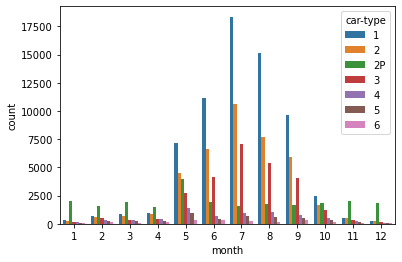

In [59]:
# visualize data overall
sns.countplot(x=data.month, hue=data['car-type'])

/var/folders/dq/pfq3tvqs1wv176zp5xp2dfs80000gn/T/ipykernel_7975/898747448.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sns.heatmap(data.groupby(['month', 'days', 'car-type']).size()[:, np.newaxis])


<AxesSubplot:>

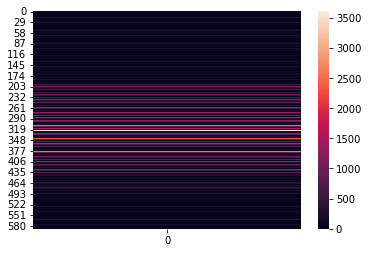

In [31]:
# a heatmap attempt 
sns.heatmap(data.groupby(['month', 'days', 'car-type']).size()[:, np.newaxis])

<AxesSubplot:>

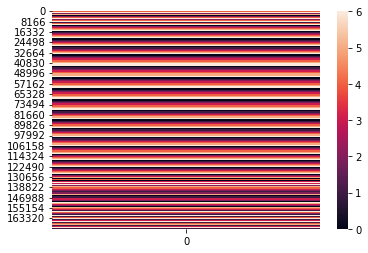

In [33]:
# another heatmap attempt
times = np.asarray(data.days).reshape(171477,1)
sns.heatmap(times)

                 Timestamp              car-id car-type      gate-name  days  \
day                                                                            
Friday 2015-05-01 00:43:28  20154301124328-262        4      entrance3     4   
Friday 2015-05-01 01:03:48  20154301124328-262        4  general-gate1     4   
Friday 2015-05-01 01:06:24  20154301124328-262        4   ranger-stop2     4   
Friday 2015-05-01 01:09:25  20154301124328-262        4   ranger-stop0     4   
Friday 2015-05-01 01:12:36  20154301124328-262        4  general-gate2     4   

        hours  month  
day                   
Friday      0      5  
Friday      1      5  
Friday      1      5  
Friday      1      5  
Friday      1      5  


<AxesSubplot:xlabel='day'>

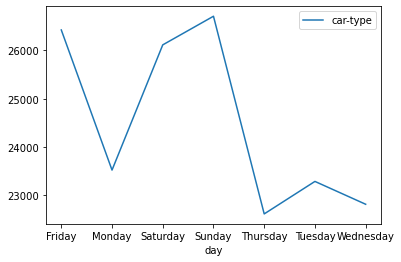

In [34]:
# this attempt did not work to separate out cars by type
graph = data.set_index('day')
print(graph.head())
graph.groupby('day').count()['car-type'].plot(legend=True)

<AxesSubplot:xlabel='month,None'>

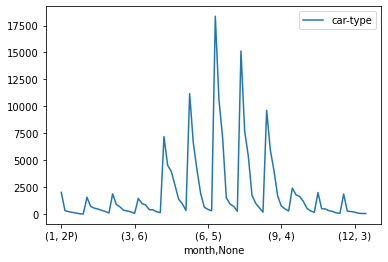

In [39]:
g = data.groupby('month')['car-type'].value_counts()
g.head()
g.plot(legend=True)

In [40]:
p = data.groupby(['month', 'car-type']).size()
p.head()

month  car-type
1      1            329
       2            247
       2P          2026
       3            176
       4            116
dtype: int64

<AxesSubplot:xlabel='month'>

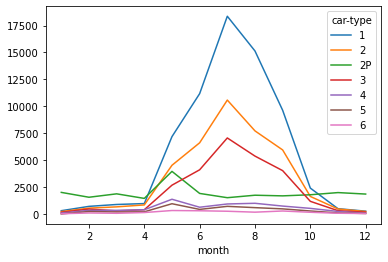

In [41]:
p.unstack().plot(legend=True)

<AxesSubplot:xlabel='days'>

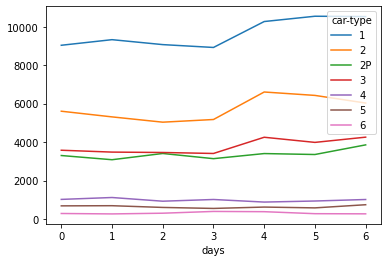

In [42]:
l = data.groupby(['days','car-type']).size()
l.unstack().plot(legend=True)

<AxesSubplot:xlabel='month,days'>

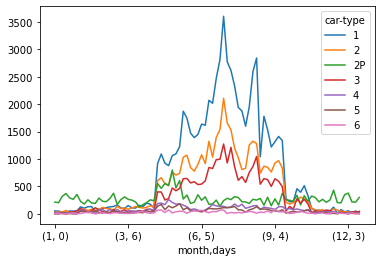

In [43]:
m = data.groupby(['month','days','car-type']).size()
m.unstack().plot(legend=True)

<AxesSubplot:xlabel='gate-name'>

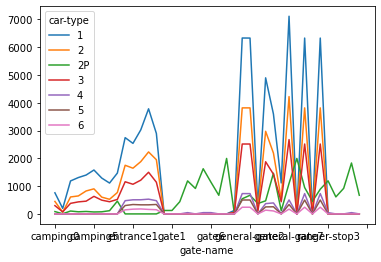

In [44]:
m = data.groupby(['gate-name','car-type']).size()
m.unstack().plot(legend=True)

<AxesSubplot:xlabel='hours'>

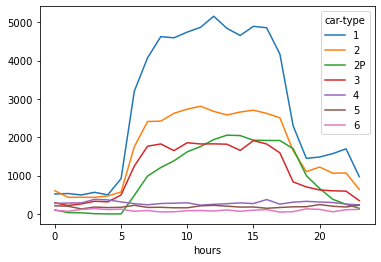

In [45]:
n = data.groupby(['hours', 'car-type']).size()
n.unstack().plot(legend=True)

In [46]:
# another heatmap attempt. not having luck with not having duplicate indexes...???
data["months2"] = pd.Categorical(data["month"], data.month.unique())
data["days2"] = pd.Categorical(data["days"], data.days.unique())
data["cars2"] = pd.Categorical(data["car-type"], data["car-type"].unique())
car_matrix = data.pivot("months2","days","car-type")
r = sns.heatmap (car_matrix, cmap='BuPu')

ValueError: Index contains duplicate entries, cannot reshape

/var/folders/dq/pfq3tvqs1wv176zp5xp2dfs80000gn/T/ipykernel_7975/2698445692.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  sns.heatmap(data.groupby(['month', 'days', 'car-type']).size()[:, np.newaxis])


<AxesSubplot:>

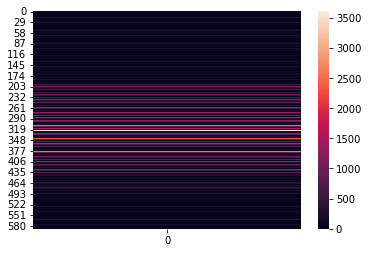

In [48]:
sns.heatmap(data.groupby(['month', 'days', 'car-type']).size()[:, np.newaxis])

<AxesSubplot:>

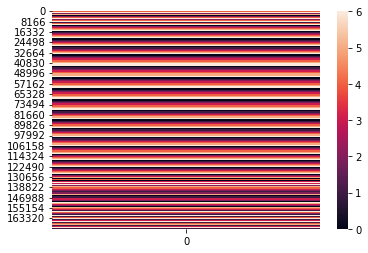

In [49]:
times = np.asarray(data.days).reshape(171477,1)
sns.heatmap(times)

In [50]:
sns.lineplot(x=data.day, y=data.groupby('car-type').count(),hue=data['car-type'])

ValueError: Data must be 1-dimensional

                 Timestamp              car-id car-type      gate-name  days  \
day                                                                            
Friday 2015-05-01 00:43:28  20154301124328-262        4      entrance3     4   
Friday 2015-05-01 01:03:48  20154301124328-262        4  general-gate1     4   
Friday 2015-05-01 01:06:24  20154301124328-262        4   ranger-stop2     4   
Friday 2015-05-01 01:09:25  20154301124328-262        4   ranger-stop0     4   
Friday 2015-05-01 01:12:36  20154301124328-262        4  general-gate2     4   

        hours  month months2 days2 cars2  
day                                       
Friday      0      5       5     4     4  
Friday      1      5       5     4     4  
Friday      1      5       5     4     4  
Friday      1      5       5     4     4  
Friday      1      5       5     4     4  


<AxesSubplot:xlabel='day'>

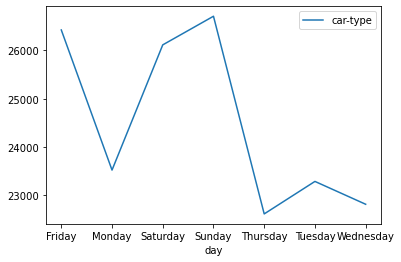

In [51]:
graph = data.set_index('day')
print(graph.head())
graph.groupby('day').count()['car-type'].plot(legend=True)

In [52]:
g = data.groupby('month')['car-type'].value_counts()
g.head()

month    
1      2P    2026
       1      329
       2      247
       3      176
       4      116
Name: car-type, dtype: int64

<AxesSubplot:xlabel='month,None'>

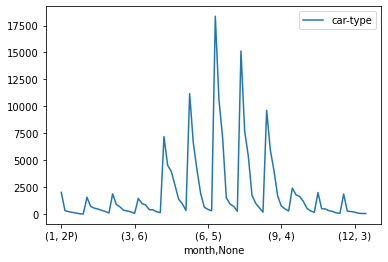

In [53]:
g.plot(legend=True)

In [54]:
p = data.groupby(['month', 'car-type']).size()
p.head()

month  car-type
1      1            329
       2            247
       2P          2026
       3            176
       4            116
dtype: int64

<AxesSubplot:xlabel='month'>

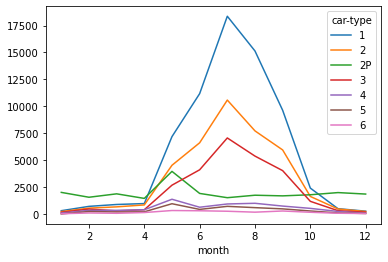

In [55]:
p.unstack().plot(legend=True)

<AxesSubplot:xlabel='days'>

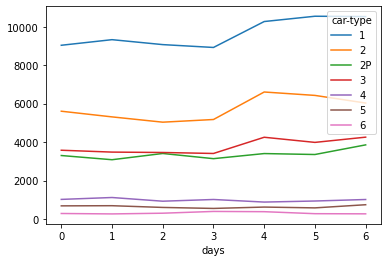

In [56]:
l = data.groupby(['days','car-type']).size()
l.unstack().plot(legend=True)

<AxesSubplot:xlabel='month,days'>

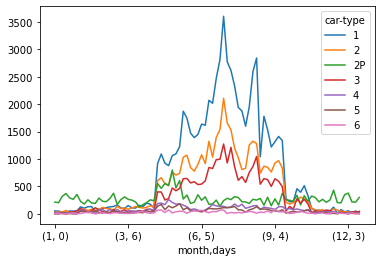

In [57]:
m = data.groupby(['month','days','car-type']).size()
m.unstack().plot(legend=True)

<AxesSubplot:xlabel='gate-name'>

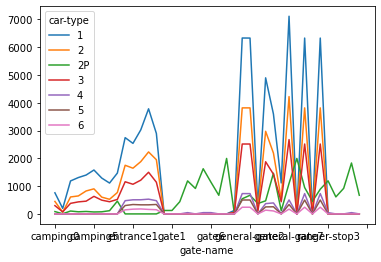

In [58]:
m = data.groupby(['gate-name','car-type']).size()
m.unstack().plot(legend=True)

In [ ]:
#Unneeded code for now.
#Keeping just in case.


#create graph class

# class Graph(object):
#
#     def __init__(self, graph_dict=None):
#         if graph_dict == None:
#             graph_dict = {}
#         self._graph_dict = graph_dict
#     def edges(self, vertex):
#         return self._graph_dict[vertex]
#     def all_vertices(self):
#         return set(self._graph_dict.keys())
#     def all_edges(self):
#         return self._generate_edges()
#     def add_vertex(self, vertex):
#         if vertex not in self._graph_dict:
#             self._graph_dict[vertex] = []
#     def add_edge(self, edge):
#         edge = set(edge)
#         v1, v2 = tuple(edge)
#         for x, y in [(v1, v2), (v2, v1)]:
#             for x in self._graph_dict:
#                 self._graph_dict[x].add(y)
#             else:
#                 self._graph_dict[x] = [y]
#     def _generate_edges(self):
#         edges = []
#         for vertex in self._graph_dict:
#             for neighbor in self._graph_dict[vertex]:
#                 if {neighbor, vertex} not in edges:
#                     edges.append({vertex, neighbor})
#         return edges
#     def __iter__(self):
#         self._iter_obj = iter(self._graph_dict)
#         return self._iter_obj
#     def __next__(self):
#         return next(self._iter_obj)
#     def __str__(self):
#         res = "vertices: "
#         for k in self._graph_dict:
#             res += str(k) + " "
#         res += "\nedges: "
#         for edge in self._generate_edges():
#             res += str(edge) + " "
#         return res
#
#
# g = Graph(g)